# XID+IR_SED_Analysis
This notebook takes the posterior of the XID+IR_SED run and examines outputs with some useful visualisation

In [1]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import pandas as pd
import seaborn as sns

In [2]:
# load up run
priors,posterior=xidplus.load(filename='./XID+IR_SED_ESB_32_added_source.pkl')

## Plot maps
1. The actual maps
2. The posterior sample maps
3. The Bayesian P value map

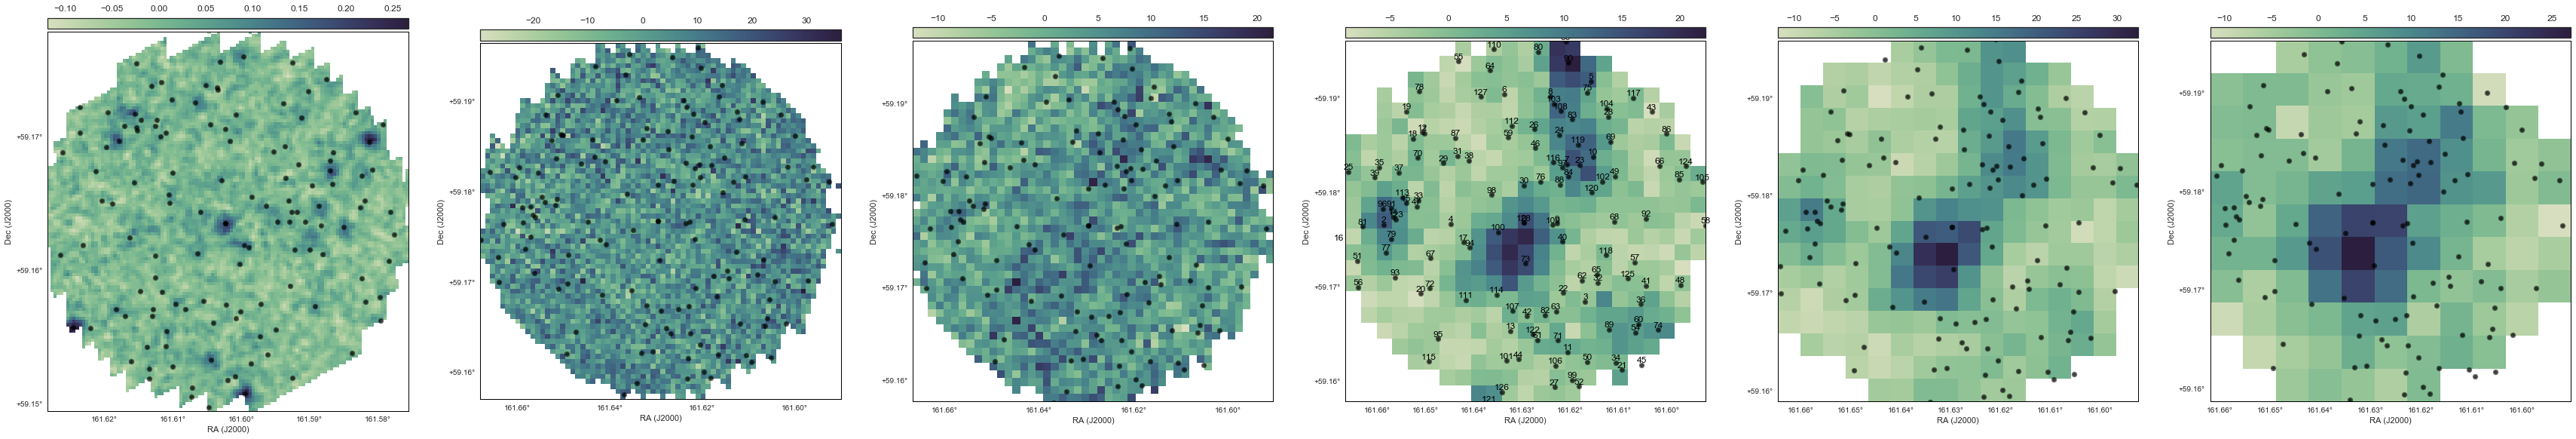

In [3]:
from xidplus import plots
orig_map=plots.plot_map(priors);
for i in range(0,priors[0].nsrc):
    orig_map[0][3].add_label(priors[0].sra[i], priors[0].sdec[i]+0.0005, np.arange(0,priors[0].nsrc)[i], relative=False)
for i in range(0,6):
    orig_map[0][i].show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=50, alpha=0.5)

In [4]:
orig_map[0][0].show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=50, alpha=0.5)


In [5]:
movie=plots.replicated_map_movie(priors,posterior, 10)

In [6]:
movie

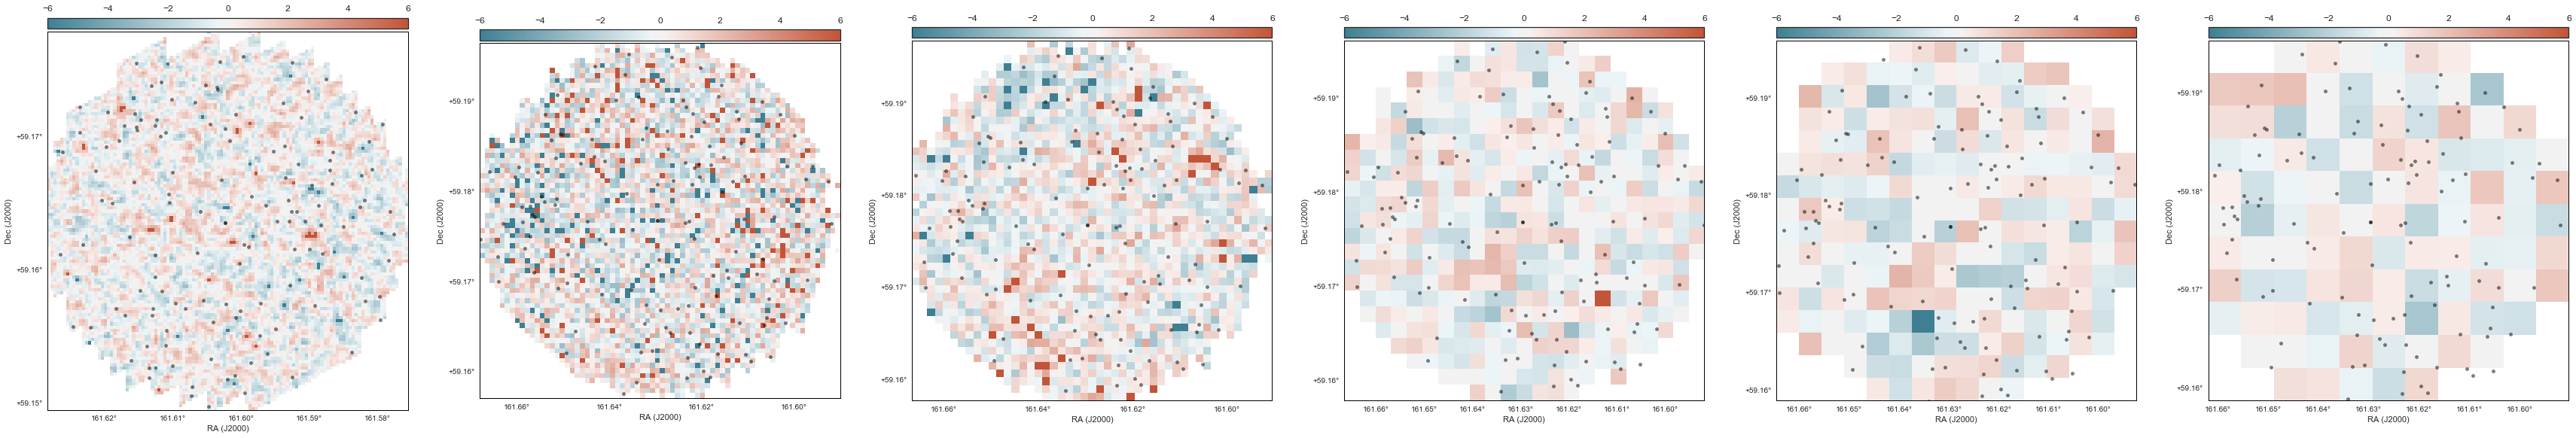

In [7]:
figs,fig=plots.plot_Bayes_pval_map(priors, posterior)

## 2D marginalised plot for fluxes

### Choose which source we want to look at


In [8]:
s1=73


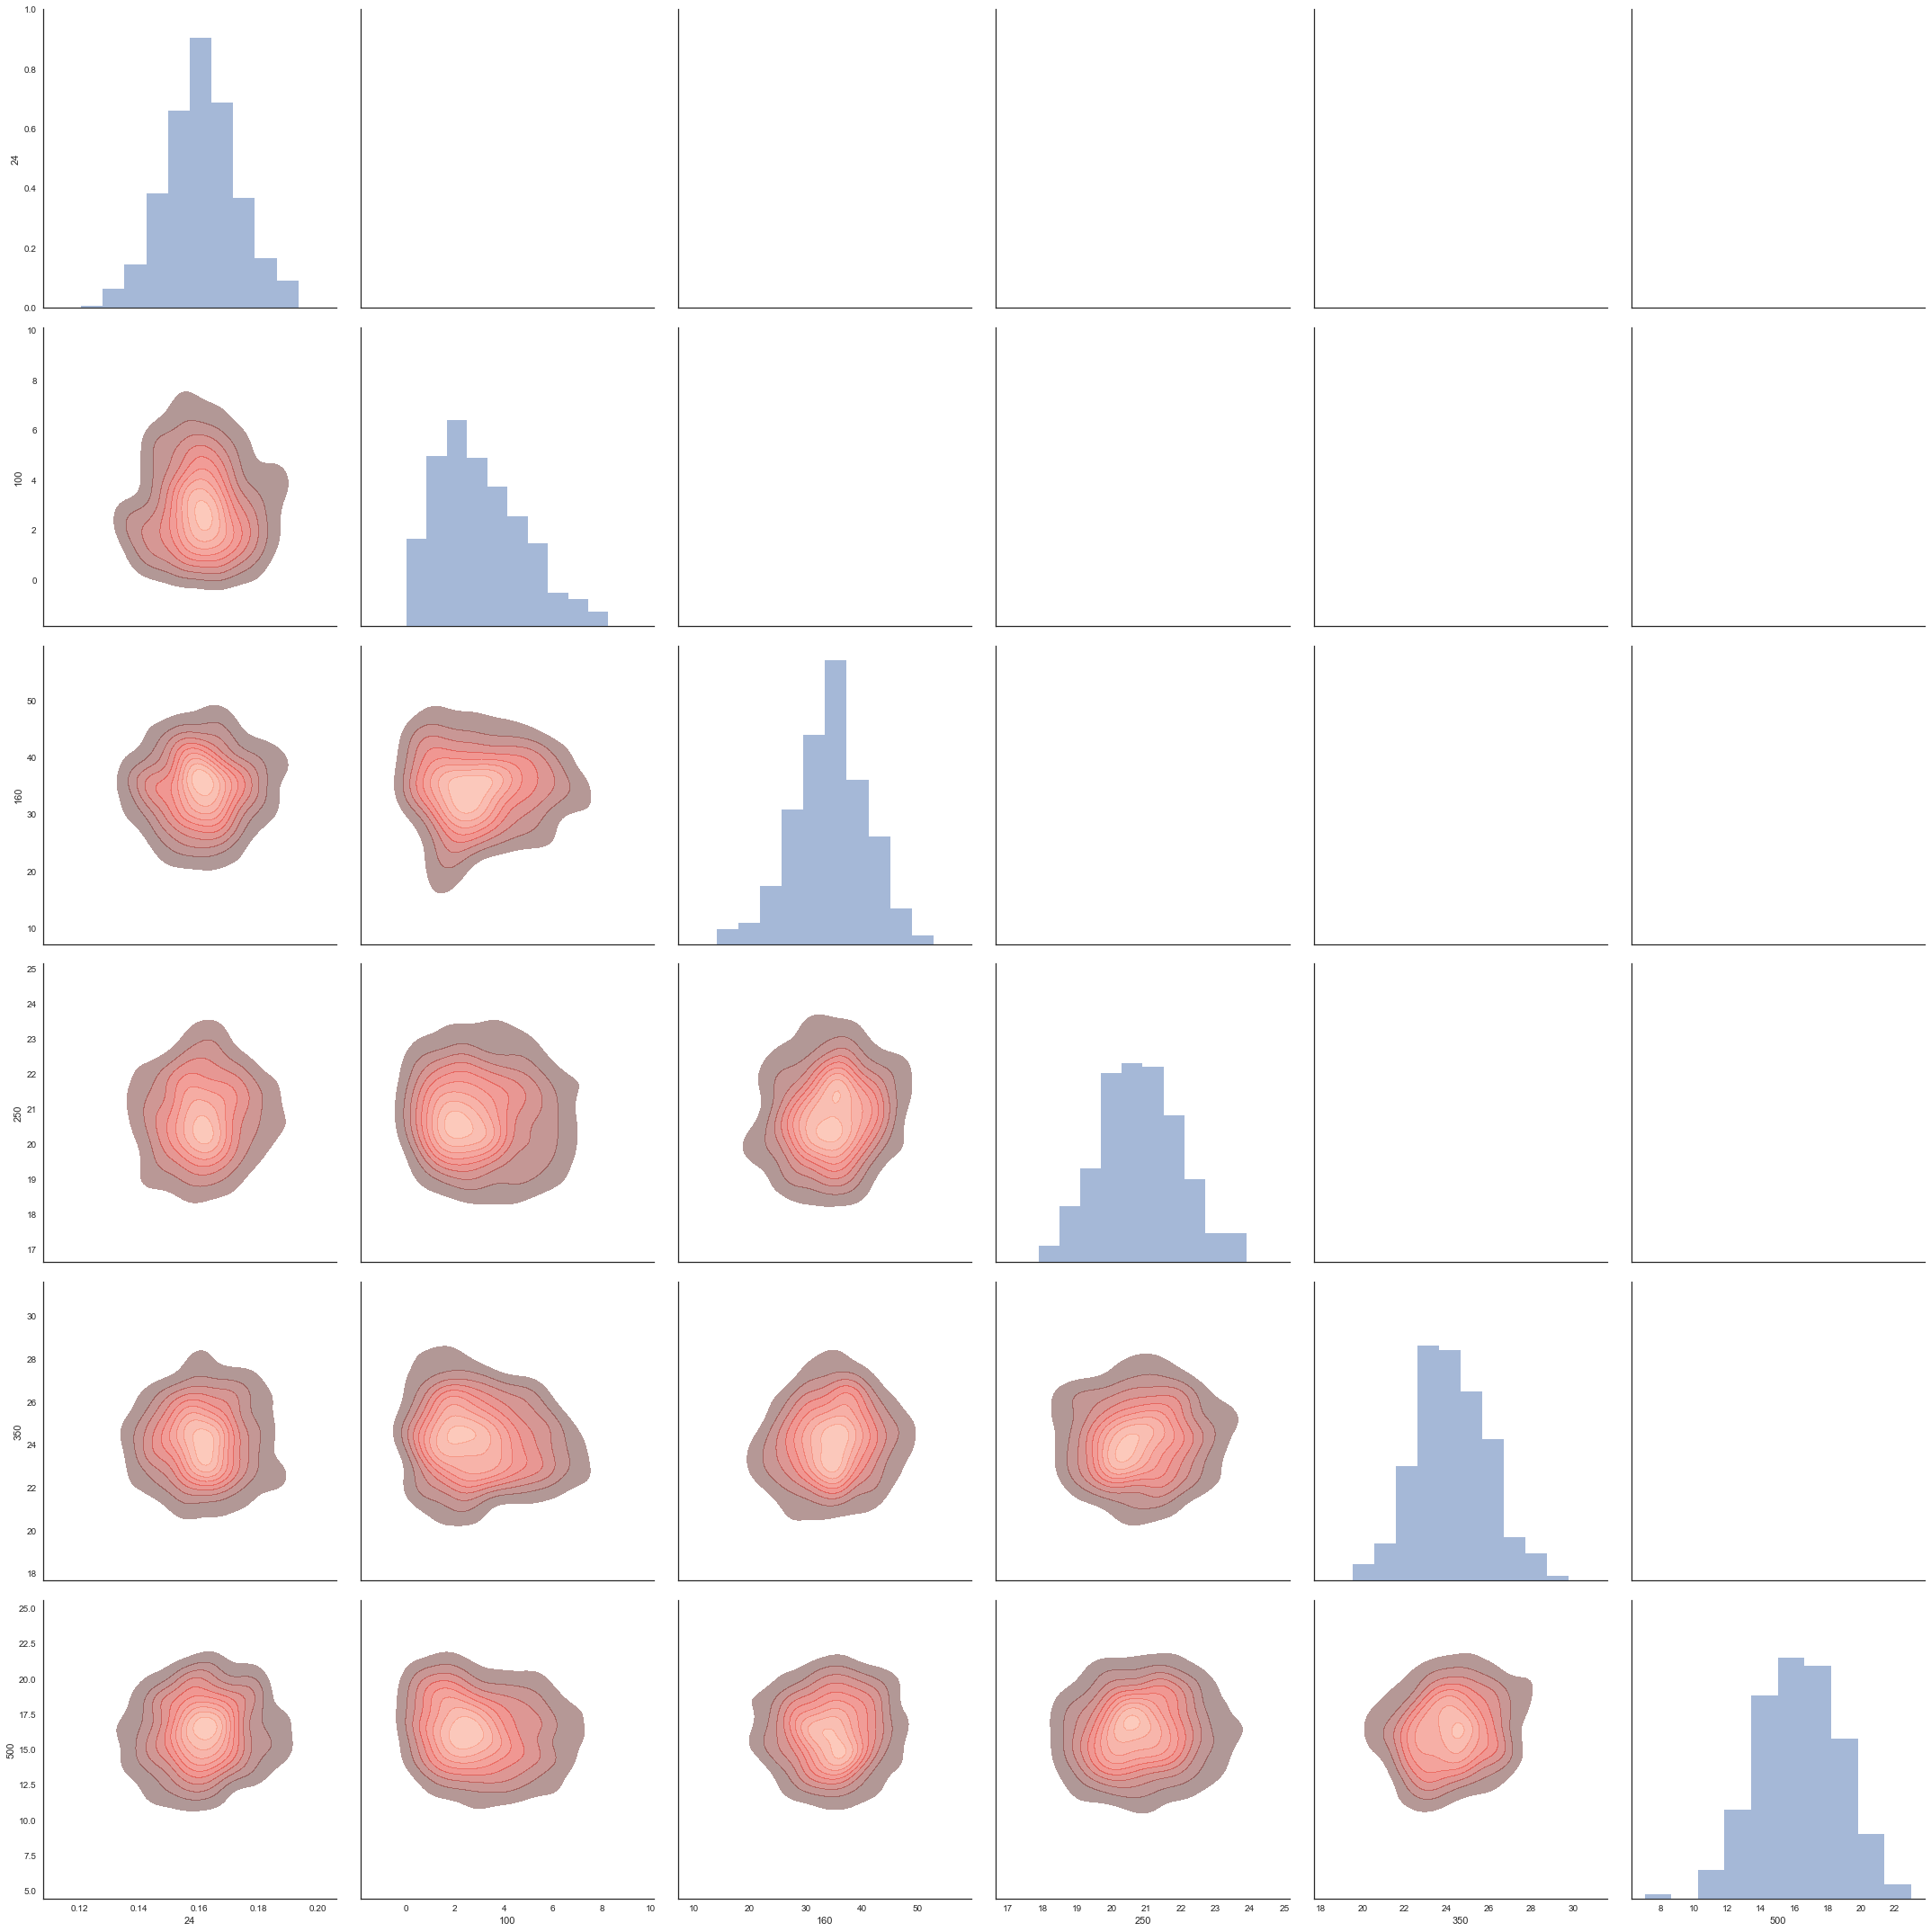

In [9]:
df = pd.DataFrame(posterior.samples['src_f'][:,:,s1],columns=[ '24','100', '160','250', '350', '500'])
g = sns.PairGrid(df,size=5)
g.map_diag(plt.hist, alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds_d",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)


## Plot Posterior SED fit samples

In [10]:
from xidplus import sed
SEDs,df =sed.berta_templates()

[24.0, 100.0, 160.0, 250.0, 350.0, 500.0]


In [11]:
temps=[15,20,21,9,30,1,5,14,0]
SEDs=SEDs[temps,:,:]
t=[x+1 for x in temps]
t.insert(0,0)
df=df[df.columns[t]]

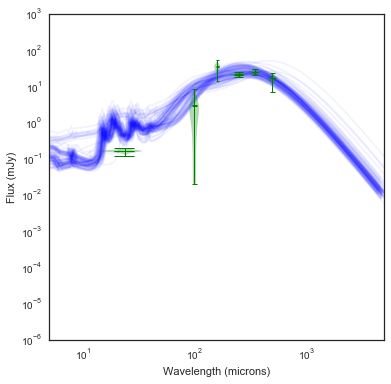

In [12]:
sns.set_style("white")

plt.figure(figsize=(6,6))
from astropy.cosmology import Planck13

violin_parts=plt.violinplot(posterior.samples['src_f'][:,3:6,s1],[250,350,500], points=60, widths=100,
                      showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('green')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('green')

violin_parts=plt.violinplot(posterior.samples['src_f'][:,0:3,s1],[24,100,160], points=60, widths=20,showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('green')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('green')

import astropy.units as u

for s in range(0,500,5):
    z= posterior.samples['z'][s,s1]
    div=(4.0*np.pi * np.square(Planck13.luminosity_distance(z).cgs))
    div=div.value

    plt.loglog((z+1.0)*df['wave'],np.power(10.0,posterior.samples['Nbb'][s,s1])*(1.0+z)*df[df.columns[np.arange(1,posterior.samples['p'].shape[2]+1)
                                        [np.random.multinomial(1, posterior.samples['p'][s,s1,:])==1]]]/div,alpha=0.05,c='b',zorder=0)
    
    #plt.plot([250,350,500, 24,100,160],posterior_IR.samples['src_f'][s,0:6,s1], 'ko', alpha=0.1, ms=10)
    #plt.plot([250,350,500],posterior.samples['src_f'][s,0:3,s1], 'ro', alpha=0.1, ms=10)
    


plt.ylim(10E-7,10E2)
plt.xlim(5,5E3)
#plt.plot([3.6,4.5,5.7,7.9],[2.91E-3,2.38E-3,2.12E-3,9.6E-3], 'ro')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (mJy)')

## Plot Table of probabilities for SED type

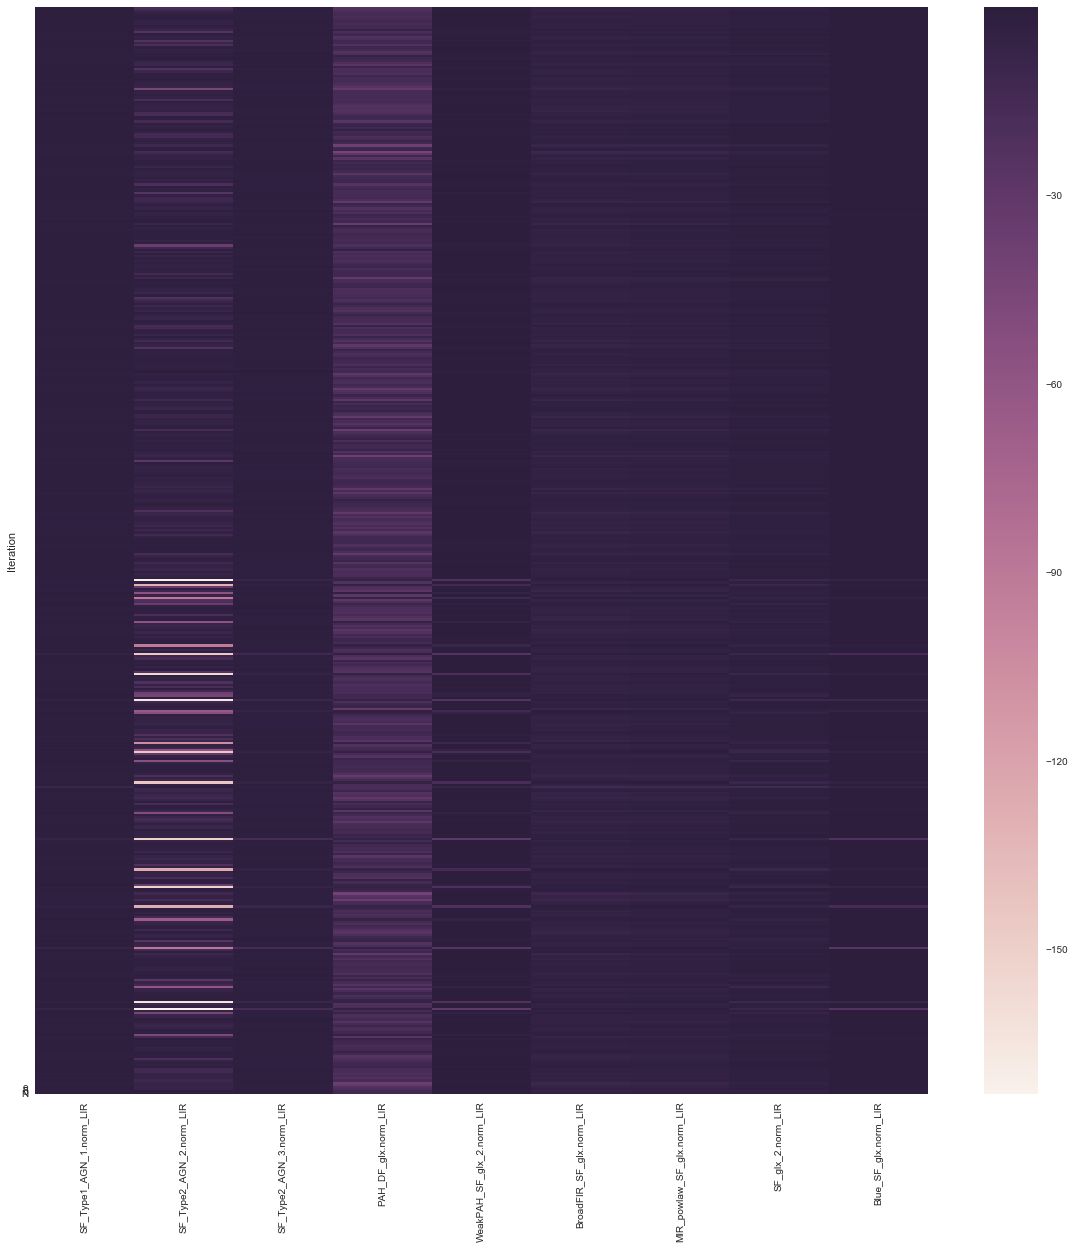

In [13]:
df=pd.DataFrame(np.log10(posterior.samples['p'][:,s1,:]),columns=df.columns.tolist()[1:])
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df,annot=False, ax=ax)
ax.set_yticklabels('None')
ax.set_ylabel('Iteration')

## Plot Marginalised LIR

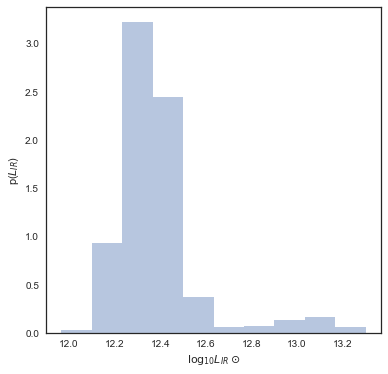

In [14]:
plt.figure(figsize=(6,6))
plt.hist(posterior.samples['Nbb'][:,s1],normed=True, alpha=0.4);
plt.xlabel(r'$\log_{10}L_{IR}\odot$')
plt.ylabel(r'p($L_{IR}$)')

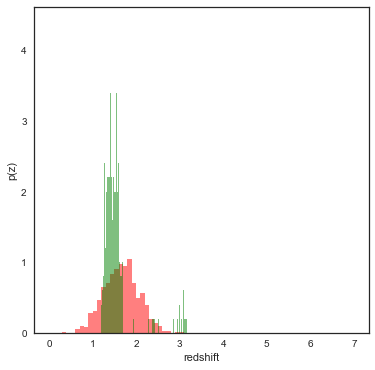

In [15]:
plt.figure(figsize=(6,6))
plt.hist(np.random.normal(priors[0].z_median[s1],priors[0].z_sig[s1],size=1000),bins=np.arange(0,7, 0.1),normed=True,color='red', alpha=0.5);
plt.hist(posterior.samples['z'][:,s1],bins=np.arange(0,7, 0.01),normed=True, alpha=0.5, color='green');
plt.xlabel('redshift')
plt.ylabel('p(z)')

## Appendix:
### Examining chains
To check runs look sensible,we can look at the samples and see if there is any drastic change between each chain. The chains are concatenated, so plotting the sample for any parameter on its own will cycle through each chain.

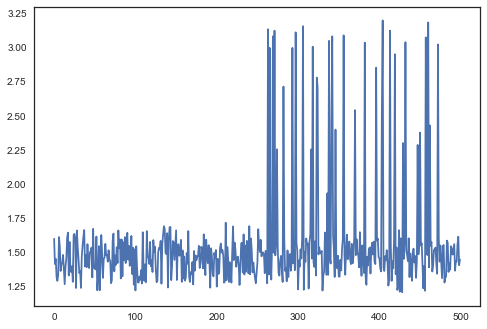

In [16]:
plt.plot(posterior.samples['z'][:,s1])

In [53]:
posterior.n_eff['Nbb'][72]

91.0

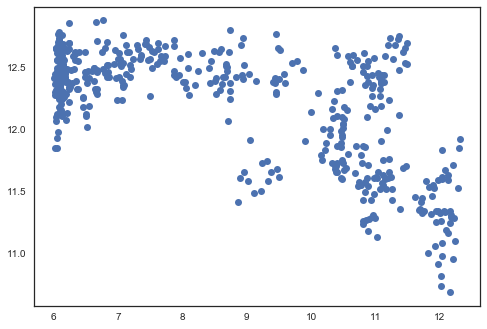

In [30]:
plt.plot(posterior.samples['Nbb'][:,6],posterior.samples['Nbb'][:,1],'o')

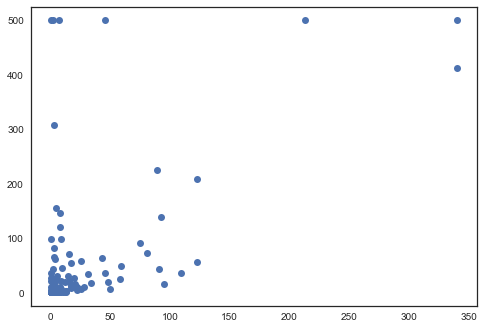

In [31]:
plt.plot(posterior.n_eff['Nbb'],posterior.n_eff['z'],'o')

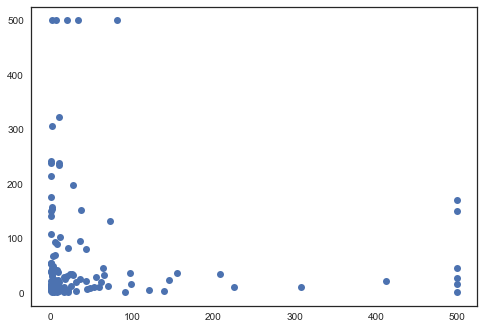

In [32]:
plt.plot(posterior.n_eff['z'],posterior.n_eff['src_f'][:,3],'o')

{'Nbb': array([   7.,    2.,   11.,   13.,    1.,   21.,    1.,    2.,    3.,
          18.,    3.,    2.,    7.,    2.,    1.,    5.,  109.,    2.,
           9.,    2.,    2.,    2.,   50.,    1.,    8.,    2.,    9.,
          26.,    1.,    4.,    2.,    9.,    2.,    4.,    2.,    2.,
           2.,   13.,    9.,    6.,    3.,   12.,    7.,   10.,    8.,
           2.,    1.,    1.,    2.,   17.,    1.,    2.,    2.,    2.,
           3.,    2.,    1.,    2.,    7.,    8.,   12.,    1.,   16.,
           1.,    7.,    7.,    7.,    6.,    1.,   43.,    7.,    6.,
          91.,  340.,  340.,   32.,   20.,   16.,   89.,   15.,   93.,
          48.,    7.,   28.,    2.,    7.,   26.,    4.,   75.,   17.,
           6.,  123.,   22.,  123.,    8.,   16.,    2.,   46.,   13.,
           5.,   95.,   34.,    1.,    1.,    4.,   58.,    3.,   59.,
           1.,  213.,   21.,    7.,   17.,   46.,   22.,    1.,    6.,
           6.,    1.,    3.,   81.,    9.,    5.,    1.,    7.,    3.,

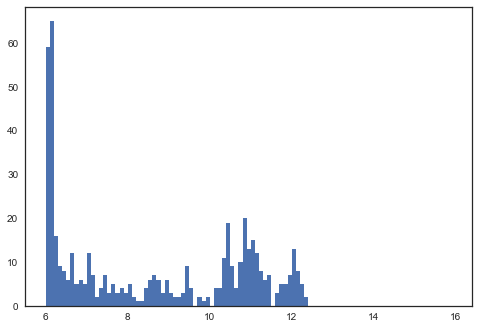

In [78]:
plt.hist(posterior.samples['Nbb'][:,6],bins=np.arange(6,16,0.1));

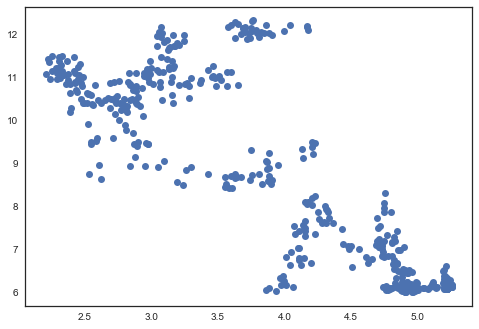

In [79]:
plt.plot(posterior.samples['z'][:,6],posterior.samples['Nbb'][:,6], 'o')